In [754]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, os.path

# Function for basis_details_decomposition (Corresponds to equation 10 and 11 from the article)
def basis_details_decomposition(images_tuple, avg_size=31):
    kernel = np.ones((avg_size, avg_size), np.float32) / avg_size ** 2
    basis_list = []
    details_list = []
    for im in images_tuple:       
        basis=cv2.boxFilter(im,-1,(avg_size,avg_size) )
        details = im - basis
        basis_list.append(basis)
        details_list.append(im - basis)
    return tuple(basis_list), tuple(details_list)


# Function for saliencies (laplacian filter + gaussian lowpass filter)
# Corresponds to equation 13 in the article
def saliency_maps(images_tuple, lapsize, rg, sigmag):
    saliency_list = []
    for im in images_tuple:
        laplacian = cv2.Laplacian(im, cv2.CV_64F, ksize=lapsize)
        abs_laplacian = np.abs(laplacian)
        saliency = cv2.GaussianBlur(abs_laplacian, (2 * rg + 1, 2 * rg + 1), sigmaX=sigmag)
        saliency_list.append(saliency)
        s=np.array(saliency_list)
        saliency_list_normalized=list((s/np.sum(s,axis=0))+1e-12)
    return tuple( saliency_list_normalized)


# Weight map function (corresponds to equation (14) from the arcticle)
def weight_map_construction(saliency_tuple):
    # Intialize weight maps to zero
    dims = saliency_tuple[0].shape
    nims = len(saliency_tuple)
    
    weight_maps = [np.zeros(dims, dtype=int) for i in range(0, nims)]
    # Loop over color channels (we have one weight map per channel)
    argmax=np.argmax(saliency_tuple,axis=0)
    # Use that information to fill the weight maps
    for i in range(0, nims):
        # Get the indicator for each pixel and fill the corresponding arrays
        weight_maps[i]= (argmax == i).astype(int)*1.
    return weight_maps


# Produce refined weights maps using guided filtering (Function for equations 15 and 16 of the article)
def refined_weight_maps(guides_tuple, images_tuple, r, eps):
    nims = len(images_tuple)
    outputs = []
    for i in range(0, nims):
        filtered = cv2.ximgproc.guidedFilter(cv2.convertScaleAbs(guides_tuple[i]),cv2.convertScaleAbs( images_tuple[i]), r, eps)
        outputs.append(filtered)
    return tuple(outputs)


# Pixel by pixel normalization
def weight_maps_normalization(weights_tuple):
    
    weights_list=np.array(list(weights_tuple))+1e-12
    weights_list_normalized=list(weights_list/np.sum(weights_list,axis=0))
    return tuple(weights_list_normalized)


def images_weighted_average(weights_tuple, images_tuple):
    size=np.array(weights_tuple).shape+(1,)
    return np.sum(np.array(weights_tuple).reshape(size) * np.array(images_tuple), axis=0)

In [755]:
##################### Loadings and other prerequisites #############################################################

# Path to the data
imgs = []
path = os.getcwd() + "/Data/rose"

# Load images from the path with different focus

valid_images = [".jpg",".png"]
for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    imgs.append(cv2.imread(os.path.join(path,f)))
images = tuple(imgs)
# Plot them
for i in range(len(images)):
    cv2.imshow("image " + str(i+1) , images[i])
    cv2.waitKey(0); cv2.destroyAllWindows(); cv2.waitKey(1)

In [756]:
# ################### A : Two scales image decomposition ###########################################################
images_gray=tuple([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])
images=tuple([img.astype(float) for img in images])
images_gray=tuple([img.astype(float) for img in images_gray])
# Size of averaging kernel for basis/details decomposition
avg_size = 31
# Get basis and details images
bases_tuple, details_tuple = basis_details_decomposition(images, avg_size)
# See result of basis/details decomposition
cv2.imshow("basis1", bases_tuple[0])
cv2.waitKey(0); cv2.destroyAllWindows(); cv2.waitKey(1)
cv2.imshow("details1", details_tuple[0])
cv2.waitKey(0); cv2.destroyAllWindows(); cv2.waitKey(1)



-1

In [757]:
# ################### B : Weight map construction with guided filtering ############################################

# Laplacian filter size
lapsize = 1
# Parameters for Gaussian lowpass filter
rg = 5
sigmag = 5
# Compute laplacians
saliency_tuple = saliency_maps(images_gray, lapsize, rg, sigmag)
cv2.imshow("saliency1", saliency_tuple[0])
cv2.waitKey(0); cv2.destroyAllWindows(); cv2.waitKey(1)


-1

Text(0.5,1,'Weight map 1 for details')

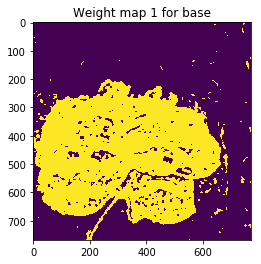

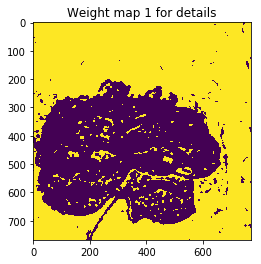

In [758]:
# Get the weight maps
weight_maps = weight_map_construction(saliency_tuple)
# Vizualize weight map, we multiply by 255 to distinguish the pixel equal to 1 from those equal to 0
plt.figure()
plt.imshow(255 * weight_maps[0])
plt.title("Weight map 1 for base")
plt.figure()
plt.imshow(255 * weight_maps[1])
plt.title("Weight map 1 for details")



In [759]:
# Refined weight maps using guided filtering
eps1 = 0.3
r1 = 45
refined_wm_basis = refined_weight_maps(weight_maps, images_gray, r1, eps1)
eps2 = 1e-6
r2 = 7
refined_wm_details = refined_weight_maps(weight_maps, images_gray, r2, eps2)



In [760]:
# Normalization of weight maps
refined_normalized_bases = weight_maps_normalization(refined_wm_basis)
refined_normalized_details = weight_maps_normalization(refined_wm_details)



In [761]:
# Fused basis and fused details
fused_bases = images_weighted_average(refined_normalized_bases, bases_tuple)
fused_details = images_weighted_average(refined_normalized_details, details_tuple)




In [ ]:
# Fused image
fused_image = fused_bases + fused_details
fused_image_uint8 = cv2.convertScaleAbs(fused_image)
cv2.imshow("Fused image", fused_image_uint8)
cv2.waitKey(0); cv2.destroyAllWindows(); cv2.waitKey(1)